# 生成器为什么可以变成协成
- 生成器和普通函数之间的区别
- 生成器对象和生成器函数之间的关系
- 生成器函数可以『暂停』的秘密

## 普通函数
> 定义一个函数，得到一个函数对象

In [44]:
def func(x):
    print(x)
func

<function __main__.func(x)>

In [45]:
# 代码对象
func.__code__

<code object func at 0x10a1c87c0, file "/var/folders/b2/gc6kky9n5m59km37j4360xc80000gn/T/ipykernel_86523/3324638433.py", line 1>

In [4]:
func_code = func.__code__
for attr in dir(func_code):
    if attr.startswith("co"):
        print(f"{attr}\t: {getattr(func_code, attr)}")

co_argcount	: 1
co_cellvars	: ()
co_code	: b't\x00|\x00\x83\x01\x01\x00d\x00S\x00'
co_consts	: (None,)
co_filename	: /var/folders/b2/gc6kky9n5m59km37j4360xc80000gn/T/ipykernel_86523/3324638433.py
co_firstlineno	: 1
co_flags	: 67
co_freevars	: ()
co_kwonlyargcount	: 0
co_lnotab	: b'\x00\x01'
co_name	: func
co_names	: ('print',)
co_nlocals	: 1
co_posonlyargcount	: 0
co_stacksize	: 2
co_varnames	: ('x',)


## 函数运行帧
> 函数对象和代码对象保存了函数的基本信息，当函数运行的时候，还需要一个对象来保存运行时的状态，这个对象就是「帧对象（Frame Object）」  
每调用一次函数，都会自动创建一个帧对象，记录当次运行的状态

In [48]:
import inspect
def foo():
    return inspect.currentframe()
# f1 = foo()
# print(f1)

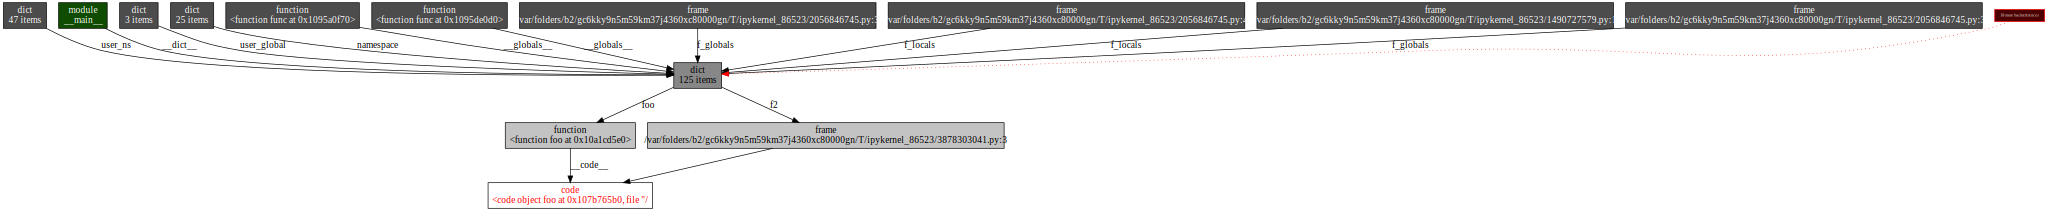

In [49]:
# 函数对象、代码对象、帧对象之间的关系
from objgraph import show_backrefs
f2 = foo()
show_backrefs(foo.__code__)

In [51]:
# 发生函数调用时的栈
from objgraph import show_refs
def bar():
    return foo()
f1 = bar()


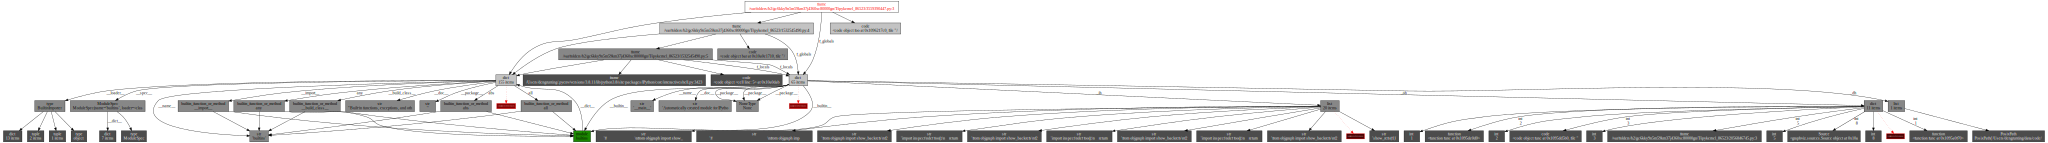

In [19]:
show_refs(f1)

## 生成器运行帧

In [52]:
import inspect

def gen_foo():
    for _ in range(20):
        yield inspect.currentframe()

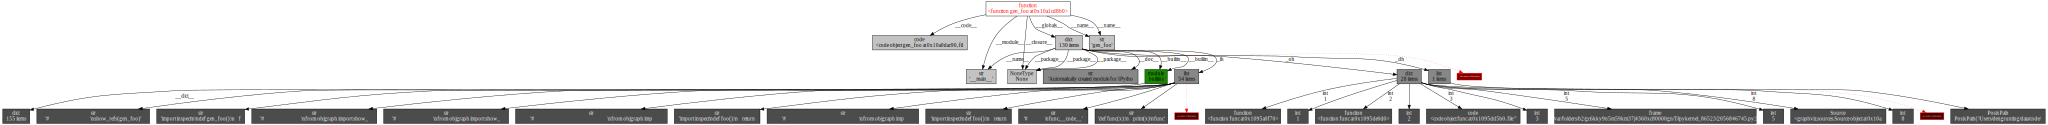

In [53]:
# 生成器函数应用的对象
show_refs(gen_foo)

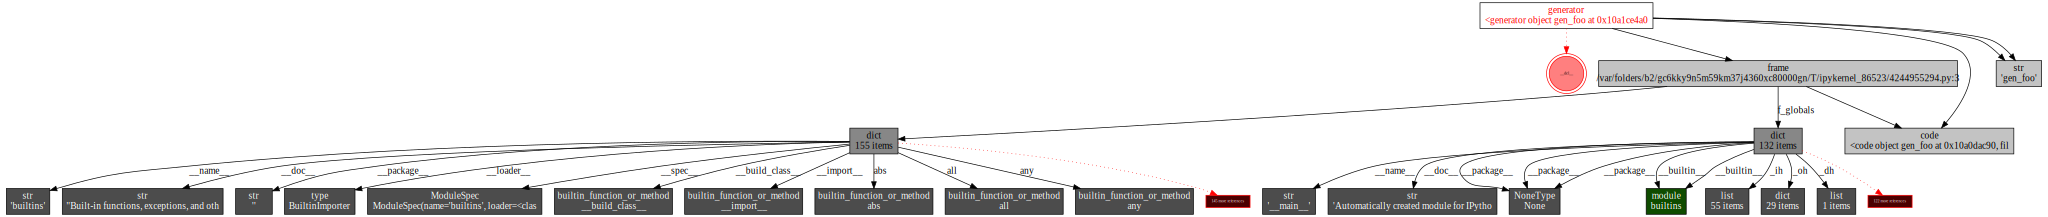

In [54]:
# 生成器引用的对象
show_refs(gen_foo())

In [55]:
## 生成器迭代过程中都是同一个frame对象
gf = gen_foo()
gi_frame = gf.gi_frame
print(gi_frame)
frames = list(gf)
for f in frames:
    print(f is gi_frame)

<frame at 0x10a115800, file '/var/folders/b2/gc6kky9n5m59km37j4360xc80000gn/T/ipykernel_86523/4244955294.py', line 3, code gen_foo>
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [57]:
# 生成器运行过程中，栈的关系图
def gen_frame_graph():
    for _ in range(10):
        graph = show_refs(inspect.currentframe())
        yield graph

In [58]:
gfg = gen_frame_graph()

def func_a(g):
    return next(g)

def func_b(g):
    return next(g)
    

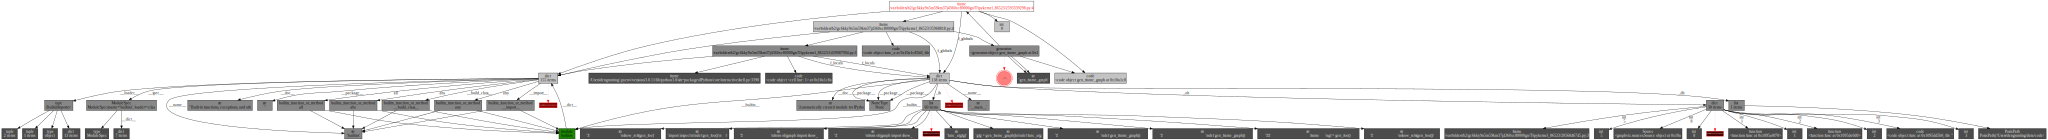

In [59]:
func_a(gfg)


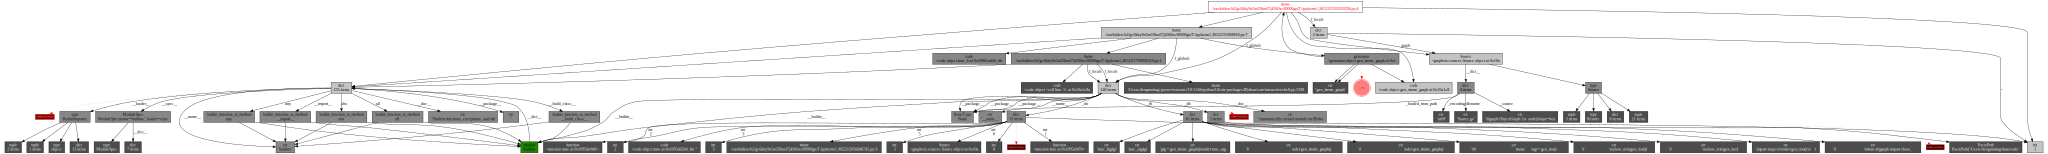

In [60]:
func_b(gfg)


### 总结
![生成器运行总结](https://raw.githubusercontent.com/fadeawaylove/article-images/master/img/20220701145106.png)

## 同步和异步

普通函数
- 调用函数：构建帧对象并入栈
- 函数执行结束：帧对象出栈并销毁

```python
# 普通函数只能同步方式运行多任务
def sync task_runner():
    task_a()
    task_b()
```


生成器函数
- 创建生成器：构建帧对象
- `next`触发运行（多次）：帧入栈
- `yield`获得结果（多次）：帧出栈
- 迭代结束：帧出栈并销毁

In [43]:
def async_task():
    yield 1
    yield 2
    yield 3

all_tasks = []
async_task_a = async_task()
async_task_b = async_task()
all_tasks.append(async_task_a)
all_tasks.append(async_task_b)

def async_task_runner():
    for task in all_tasks:
        print(next(task))
        
async_task_runner()


1
1


总结：
让一个函数可以多次迭代运行其中的代码，这是生成器最本质的作用，迭代产生的数据只是迭代执行代码的自然结果。